# SAT scores and demografics in NY

This is a DataQuest guided project that aims to compare demographic factos such as NY districts, race, gender, income and students' SAT scores.
The datasets used are 2011 NYC School Surveys:
https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8


# Read in the data

In [14]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [15]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [16]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [17]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [18]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [19]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [20]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [21]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [22]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [23]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Set up matplotlib to work in Jupyter notebook

In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Bar plot correlation betweeen various fields and sat_score

<IPython.core.display.Javascript object>


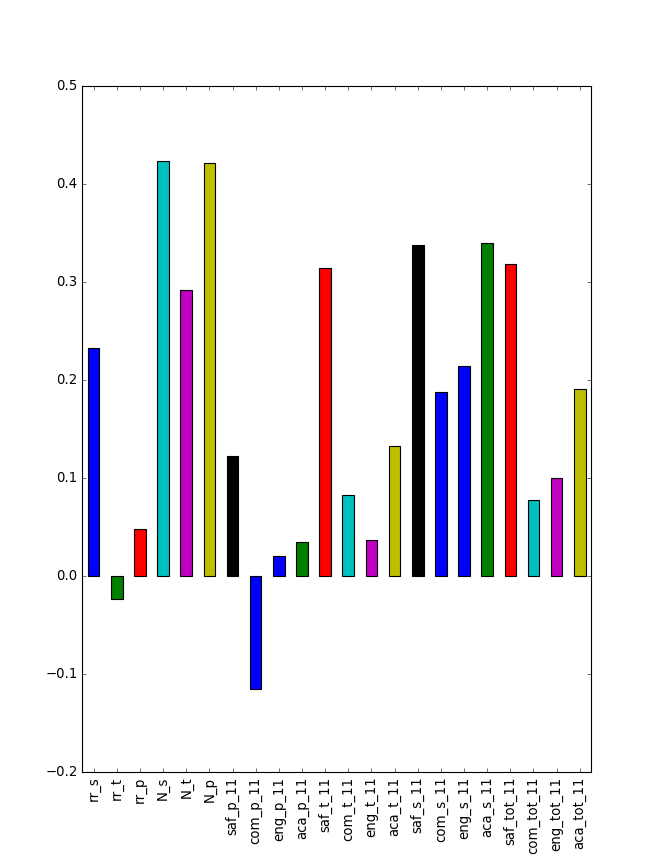

In [28]:
combined.corr()["sat_score"][survey_fields].plot.bar()

There is a high correlation between N_s, N_t and N_p columns and sat_scores. Those columns refer to the number of teachers, students and parents who responded to the survey. We've also noticed above, that there's a strong correlation between enrollment and sat_scores, so it makes sense. 

Sat_scores also correlates positively with saf_t_11, saf_s_11 and saf_tot_11. Those columns measure the perception of safety by students and teachers. This suggests that higher percieved safety has a positive impact in the sat results.

There's also a significat correlation between sat_scores and aca_s_11 and aca_tot_11 columns, that measure how the students perceive the academic standards. On the other hand, there is no significant correlation between how teachers or parents perceive it.




# Which schools have low safety scores

<IPython.core.display.Javascript object>


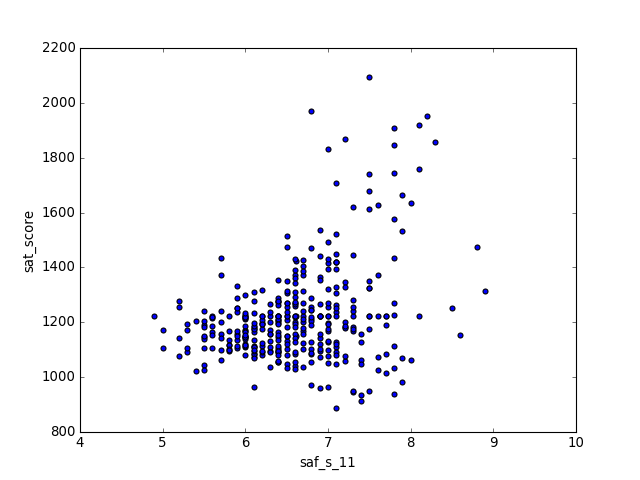

In [30]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

By looking at the scatter plot, we may say there is a positivi correlation between perceived safety and sat_scores, but not a strong one. There are a few high safety(8/9) scores and high sat scores (1800-2200), but not that many. There are also a few low safety/low sat scores (5-6/1000-1400). 

Map out safety scores:
- Compute average safety score for each district
- Make a map that shows safety scores by district

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = combined['lon'].tolist()
latitudes = combined['lat'].tolist()

m.scatter(x= longitudes, y= latitudes, s=20, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')

plt.show()

ValueError: to_rgba: Invalid rgba arg "6.7686111111111105"
to_rgb: Invalid rgb arg "6.7686111111111105"
cannot convert argument to rgb sequence

It looks like Brooklyn schools have a lower perceived safety score than Upper Manhattan and the Bronx ones.

# Racial differences in SAT performance
- white_per
- asian_per
- black_per
- hispanic_per

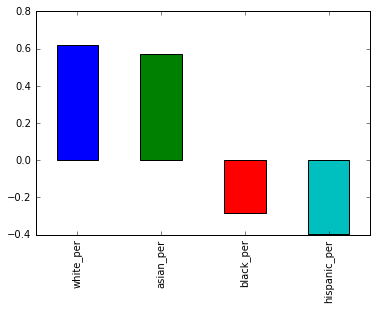

In [65]:
%matplotlib inline

race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()


There are higher SAT results in schools with a higher number of white and asians vs schools with black and hispanic students. The reason behind it can be very complex and most likely it depends on school locations, school funding, perceived safety, academic standards etc.

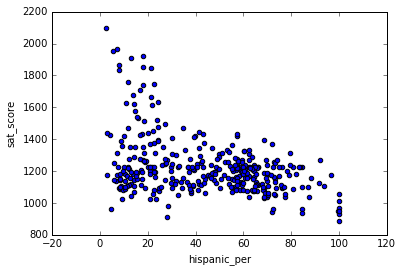

In [66]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

There is a negative correlation between the sat_scores and number of hispanic stundents enrolled, but not a strong one.

Display schools with a hispanic_per greater than 95%.

In [68]:
hispanic = combined[combined['hispanic_per'] > 95]
hispanic['School Name']

44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

These are schools with a high number of imigrants, who's English isn't the first language, and that should explain the lower SAT scores.

In [72]:
hispanic = combined[combined['hispanic_per'] < 10]
hispanic = hispanic[hispanic['sat_score'] > 1800]
hispanic['School Name']

37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object

These are very well rated schools, with a passing entrance exam and high funding (college preparation high schools).

# Gender and SAT Scores
- male_per
- female_per

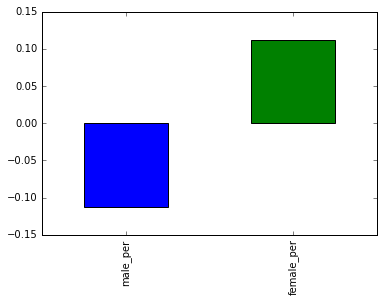

In [75]:
gender = ['male_per', 'female_per']
combined.corr()['sat_score'][gender].plot.bar()

It looks like females perform significantly better than male at SATs.

Schools with high SAT and high female_per.

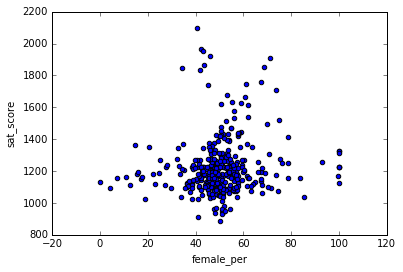

In [76]:
combined.plot.scatter(x='female_per', y='sat_score')

Based on this scatter plot, there isn't a significat correlation between schools with high number of females and schools with high sat scores, but there are a few schools where that is true (higher than 60% females/over 1700 SAT average scores). Let's find those schools.

females = combined[combined['female_per'] > 60]
females = females[females['sat_score'] > 1700]
females['School Name']

Again, these are very high rated, selective shools, that have bigger funds and most likely higher perceived academic standards, that we already noticed above, has a significat impact on sat_scores.

# Students that took AdcancedPlacement exams
- what's the percentage of students in each school that took an AP exam
- investigate the relationship between AP scores and SAT scores

In [80]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01,0.305756
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01,0.098985
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01,0.031773
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01,0.351577
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01,0.158091


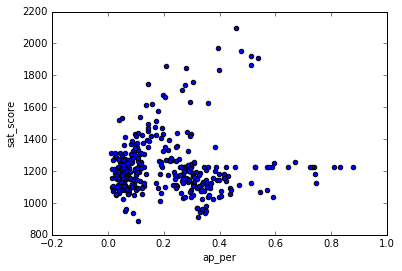

In [81]:
combined.plot.scatter(x='ap_per', y='sat_score')

There is a correlation between sat_scores and ap_scores, but not a strong one.